## Homework

The goal of this notebook is:

* Obtain a CNN classification model, performing hyperparameter tuning
* Show some images, and see if the dataset is unbalanced
* Evaluate training metrics
* Evaluate classification metrics
* Discussion
* Export model to tf-lite

# Load Dataset

In [1]:

import keras
from keras.datasets import mnist
import pandas as pd
import seaborn as sns
import numpy as np
import keras


#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

# Explore data

### Show some images

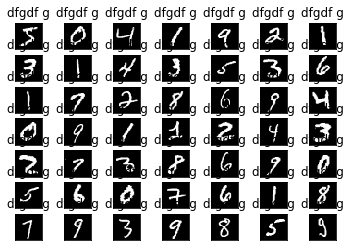

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(49):
  plt.subplot(7,7,i+1)
  #plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  


In [7]:
for i in range(7):
  start = i*7
  end = i*7+7
  print(y_train[start:end])

[5 0 4 1 9 2 1]
[3 1 4 3 5 3 6]
[1 7 2 8 6 9 4]
[0 9 1 1 2 4 3]
[2 7 3 8 6 9 0]
[5 6 0 7 6 1 8]
[7 9 3 9 8 5 9]


At first sight, there are pictures that are very clear. Others have strange shapes, which could be confusing even to humans.

### Check class distribution

<AxesSubplot:ylabel='count'>

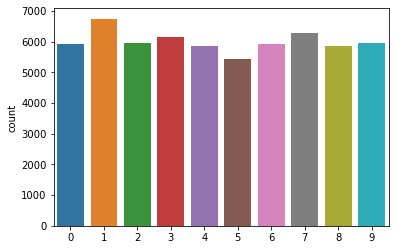

In [106]:
sns.countplot(x=y_train)

The dataset is balanced :)

### Check value ranges

In [116]:
min = np.min(X_train[0].ravel())
max= np.max(X_train[0].ravel())

print('min value',min,'- max value',max)

min value 0 - max value 255


Images are 8 bits [0-255] In the next step, this range should be normalized

# Preprocessing

### Normalization (0-255) -> (0,1)

In [117]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape) #X_train shape: (60000, 28, 28)

X_train shape: (60000, 28, 28)


### Convert to one hot encoding

In [72]:
#set number of categories
num_category = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

# Model definition
Let's explore 2 different CNN architectures
* get_model_small
* get_model_large

In [73]:

from tensorflow.keras import layers
from tensorflow.keras import models

def get_model_small(dropout=0.5,inner_layer=128): 

    input_shape = (28,28,1)
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(inner_layer, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_category, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy'])
    
    return model


def get_model_large(dropout=0.5,inner_layer=128): 

    input_shape = (28,28,1)
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(inner_layer, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_category, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy'])
    
    return model

The main evaluation metric will be accuracy

In [74]:
def model_train(model,num_epoch=2,version='model'):
    batch_size = 256
    checkpoint = keras.callbacks.ModelCheckpoint(
        version+'_{val_accuracy:.3f}.h5',
        save_best_only=True,
        monitor='val_accuracy',
        initial_value_threshold=0.6,
        mode='max'
    )
    
    history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=num_epoch,
            verbose=1,
            callbacks=[checkpoint],
            validation_data=(X_test, y_test))

    return history

show training progress

In [43]:
import matplotlib.pyplot as plt


def plot_history(scores):

    fig = plt.figure(figsize=(15,15))
    #Plot 1
    plt.subplot(2,2,1)
    plt.title('Train Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'])
    
    for score in scores:    
        history,label = score['history'],score['label']
        plt.plot(history['accuracy'],label =label)
        plt.legend(loc='best')
        
    #Plot 2
    plt.subplot(2,2,2)
    plt.title('Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    for score in scores:    
        history,label = score['history'],score['label']   
        plt.plot(history['val_accuracy'],label =label)
        plt.legend(loc='best')
    #Plot 3
    plt.subplot(2,2,3)
    plt.title('train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    for score in scores:    
        history,label = score['history'],score['label']  
        plt.plot(history['loss'],label =label)
        plt.legend(loc='best')
    #Plot 4
    plt.subplot(2,2,4)
    plt.title('validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    for score in scores:    
        history,label = score['history'],score['label']    
        plt.plot(history['val_loss'],label =label)       
        plt.legend(loc='best')
    plt.tight_layout()

# Train models

* Train architecture (small)
* Explore different `inner layer sizes`


In [47]:
inner_layers = [10,40,70,100]
scores = []

for inner_layer in inner_layers:
    print(f'layer={inner_layer}')
    model = get_model_small(dropout=0.5,inner_layer=inner_layer)
    history = model_train(model,num_epoch=10,version='model_v1')
    scores.append({'history':history.history,'label':f'layer={inner_layer}'})

layer=10
Epoch 1/10
235/235 [==============================] - 31s 129ms/step - loss: 2.3041 - accuracy: 0.0982 - val_loss: 2.2982 - val_accuracy: 0.1323
Epoch 2/10
235/235 [==============================] - 30s 129ms/step - loss: 2.2982 - accuracy: 0.1094 - val_loss: 2.2926 - val_accuracy: 0.1512
Epoch 3/10
235/235 [==============================] - 30s 130ms/step - loss: 2.2926 - accuracy: 0.1170 - val_loss: 2.2868 - val_accuracy: 0.1515
Epoch 4/10
235/235 [==============================] - 30s 129ms/step - loss: 2.2870 - accuracy: 0.1255 - val_loss: 2.2805 - val_accuracy: 0.1534
Epoch 5/10
235/235 [==============================] - 31s 131ms/step - loss: 2.2815 - accuracy: 0.1329 - val_loss: 2.2730 - val_accuracy: 0.1623
Epoch 6/10
235/235 [==============================] - 31s 132ms/step - loss: 2.2743 - accuracy: 0.1377 - val_loss: 2.2640 - val_accuracy: 0.1784
Epoch 7/10
235/235 [==============================] - 31s 133ms/step - loss: 2.2663 - accuracy: 0.1447 - val_loss: 2.2531

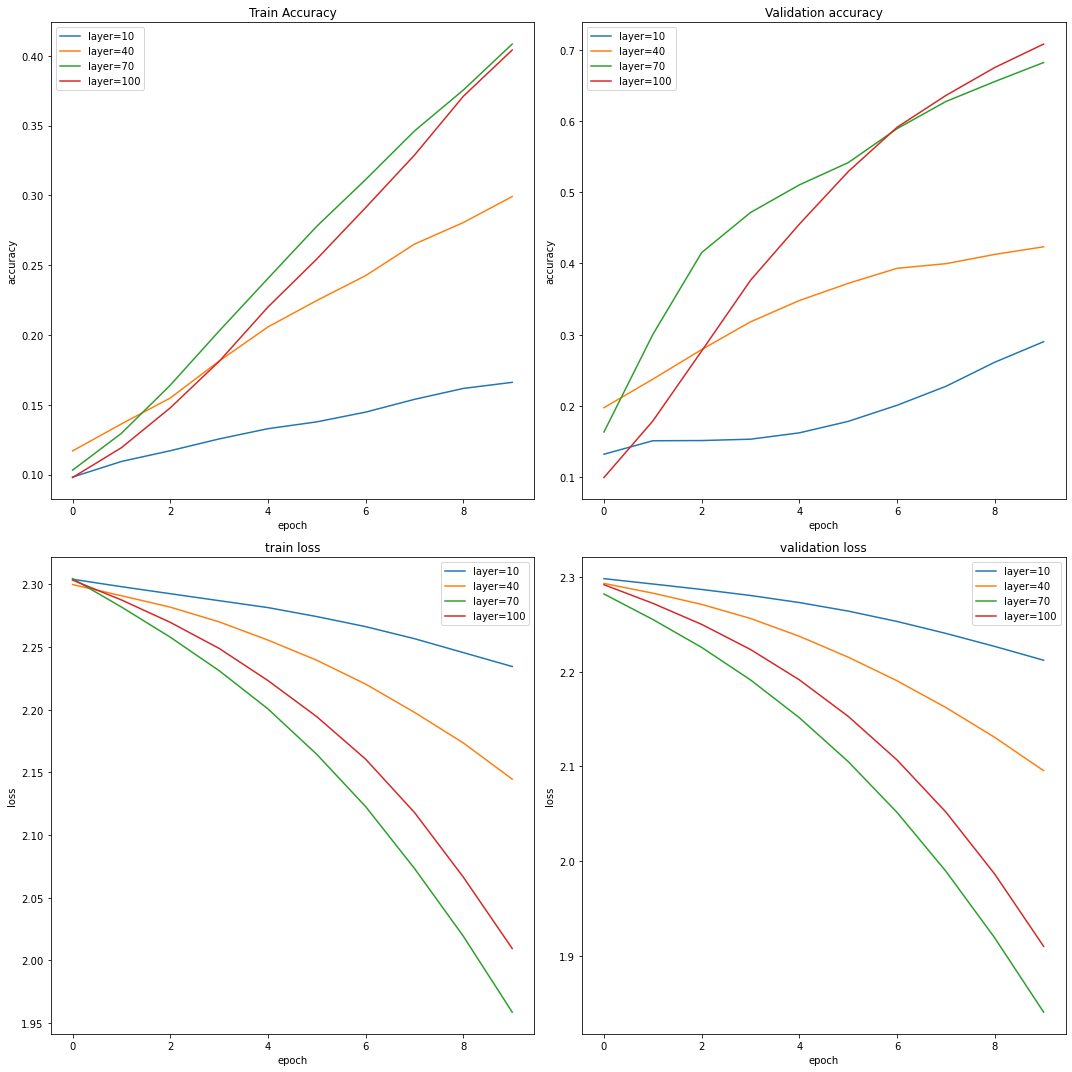

In [48]:
plot_history(scores)


Accuracy with inner layer 100 gave the best results

* Train architecture (small) with inner layer 100
* Explore different `dropout` values

In [49]:
dropout_choices = [0,0.25,0.5]
scores = []

for dropout in dropout_choices:
    print(f'dropout={dropout}')
    model = get_model_small(dropout=dropout,inner_layer=100)
    history = model_train(model,num_epoch=14,version='model_v2')
    scores.append({'history':history.history,'label':f'dropout={dropout}'})

dropout=0
Epoch 1/14
235/235 [==============================] - 31s 130ms/step - loss: 2.2832 - accuracy: 0.2161 - val_loss: 2.2562 - val_accuracy: 0.3472
Epoch 2/14
235/235 [==============================] - 30s 127ms/step - loss: 2.2269 - accuracy: 0.4329 - val_loss: 2.1953 - val_accuracy: 0.4867
Epoch 3/14
235/235 [==============================] - 30s 126ms/step - loss: 2.1601 - accuracy: 0.5247 - val_loss: 2.1179 - val_accuracy: 0.5633
Epoch 4/14
235/235 [==============================] - 29s 124ms/step - loss: 2.0713 - accuracy: 0.6028 - val_loss: 2.0129 - val_accuracy: 0.6288
Epoch 5/14
235/235 [==============================] - 29s 124ms/step - loss: 1.9494 - accuracy: 0.6582 - val_loss: 1.8679 - val_accuracy: 0.6768
Epoch 6/14
235/235 [==============================] - 30s 127ms/step - loss: 1.7827 - accuracy: 0.6951 - val_loss: 1.6738 - val_accuracy: 0.7180
Epoch 7/14
235/235 [==============================] - 29s 123ms/step - loss: 1.5711 - accuracy: 0.7236 - val_loss: 1.441

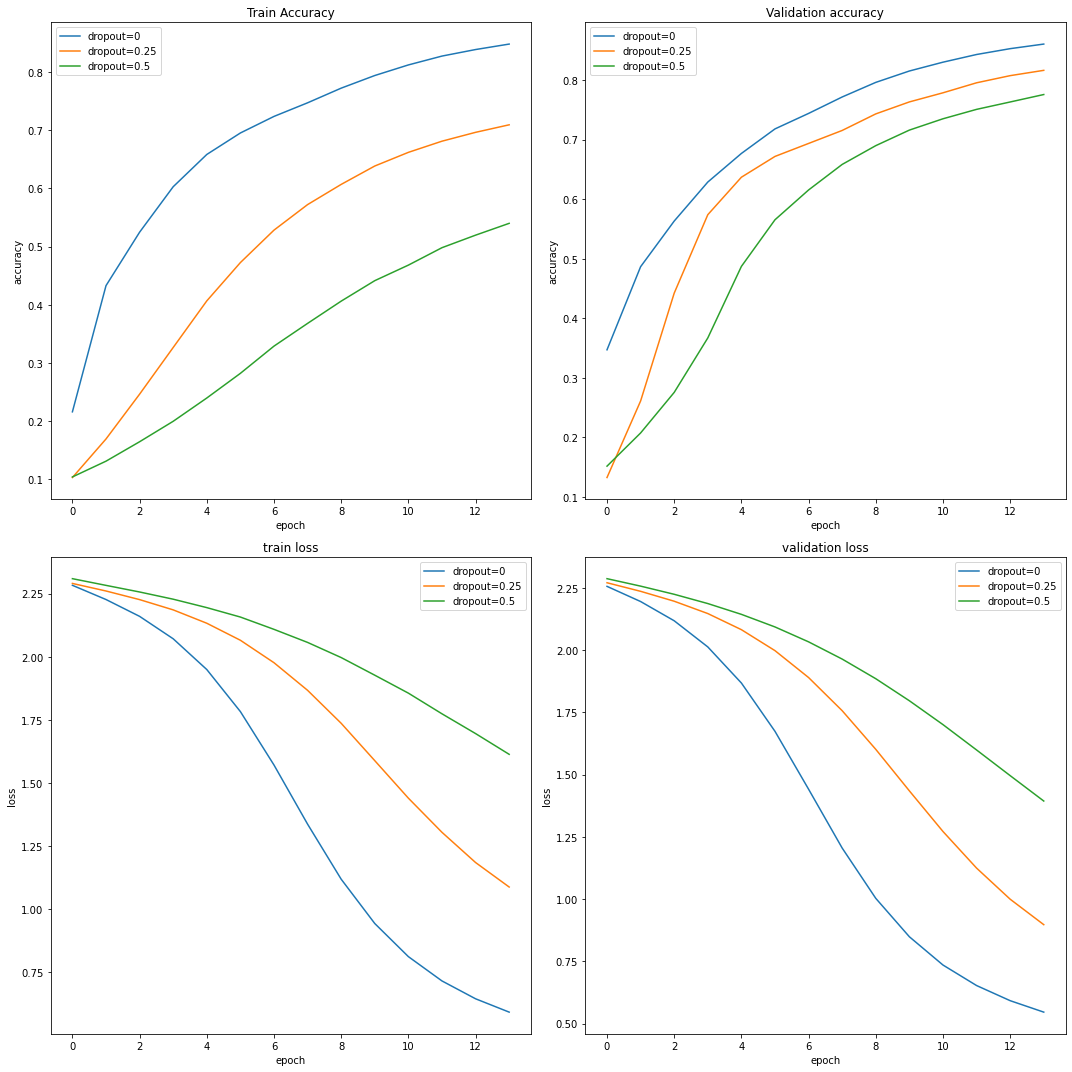

In [50]:
plot_history(scores)

A high dropout makes the model improve very little in each epoch

### Train final small architecture

* Train model with inner layer 100 and dropout=0.1

In [77]:
model = get_model_small(dropout=0.1,inner_layer=100)
history = model_train(model,num_epoch=80,version='model_v2')

Epoch 1/80
235/235 [==============================] - 33s 139ms/step - loss: 2.2984 - accuracy: 0.1476 - val_loss: 2.2855 - val_accuracy: 0.1878
Epoch 2/80
235/235 [==============================] - 33s 139ms/step - loss: 2.2764 - accuracy: 0.2164 - val_loss: 2.2612 - val_accuracy: 0.2842
Epoch 3/80
235/235 [==============================] - 33s 139ms/step - loss: 2.2513 - accuracy: 0.3034 - val_loss: 2.2327 - val_accuracy: 0.3817
Epoch 4/80
235/235 [==============================] - 33s 138ms/step - loss: 2.2212 - accuracy: 0.3823 - val_loss: 2.1973 - val_accuracy: 0.4757
Epoch 5/80
235/235 [==============================] - 33s 139ms/step - loss: 2.1824 - accuracy: 0.4516 - val_loss: 2.1518 - val_accuracy: 0.5325
Epoch 6/80
235/235 [==============================] - 32s 138ms/step - loss: 2.1321 - accuracy: 0.5035 - val_loss: 2.0915 - val_accuracy: 0.5724
Epoch 7/80
235/235 [==============================] - 33s 139ms/step - loss: 2.0637 - accuracy: 0.5469 - val_loss: 2.0089 - val_ac

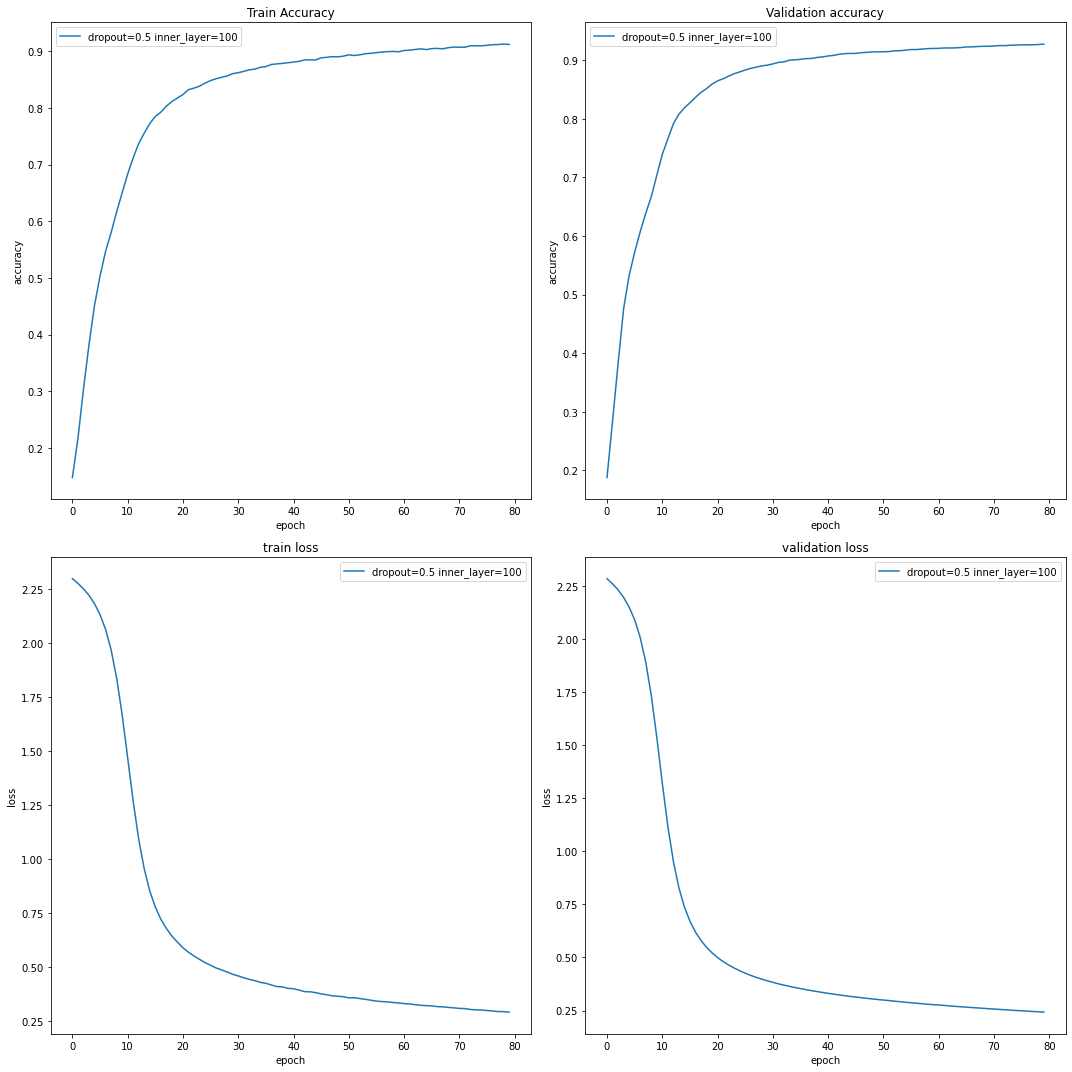

In [78]:
plot_history([{'history':history.history,'label':f'dropout={dropout} inner_layer={100}'}])

The model achieved `93%` accuracy!

### Train large model
* Explore different inner layers

In [55]:
inner_layers = [50,100,150]
scores = []

for inner_layer in inner_layers:
    print(f'layer={inner_layer}')
    model =get_model_large(dropout=0,inner_layer=inner_layer)
    history = model_train(model,num_epoch=16,version='model_v3')
    scores.append({'history':history.history,'label':f'layer={inner_layer}'})



layer=50
Epoch 1/16
235/235 [==============================] - 29s 124ms/step - loss: 2.2906 - accuracy: 0.1699 - val_loss: 2.2837 - val_accuracy: 0.1952
Epoch 2/16
235/235 [==============================] - 29s 124ms/step - loss: 2.2744 - accuracy: 0.2225 - val_loss: 2.2655 - val_accuracy: 0.2353
Epoch 3/16
235/235 [==============================] - 30s 129ms/step - loss: 2.2532 - accuracy: 0.2697 - val_loss: 2.2407 - val_accuracy: 0.2934
Epoch 4/16
235/235 [==============================] - 29s 122ms/step - loss: 2.2239 - accuracy: 0.3307 - val_loss: 2.2055 - val_accuracy: 0.3630
Epoch 5/16
235/235 [==============================] - 29s 122ms/step - loss: 2.1828 - accuracy: 0.3852 - val_loss: 2.1563 - val_accuracy: 0.4148
Epoch 6/16
235/235 [==============================] - 29s 122ms/step - loss: 2.1238 - accuracy: 0.4365 - val_loss: 2.0835 - val_accuracy: 0.4753
Epoch 7/16
235/235 [==============================] - 29s 121ms/step - loss: 2.0366 - accuracy: 0.4964 - val_loss: 1.9775

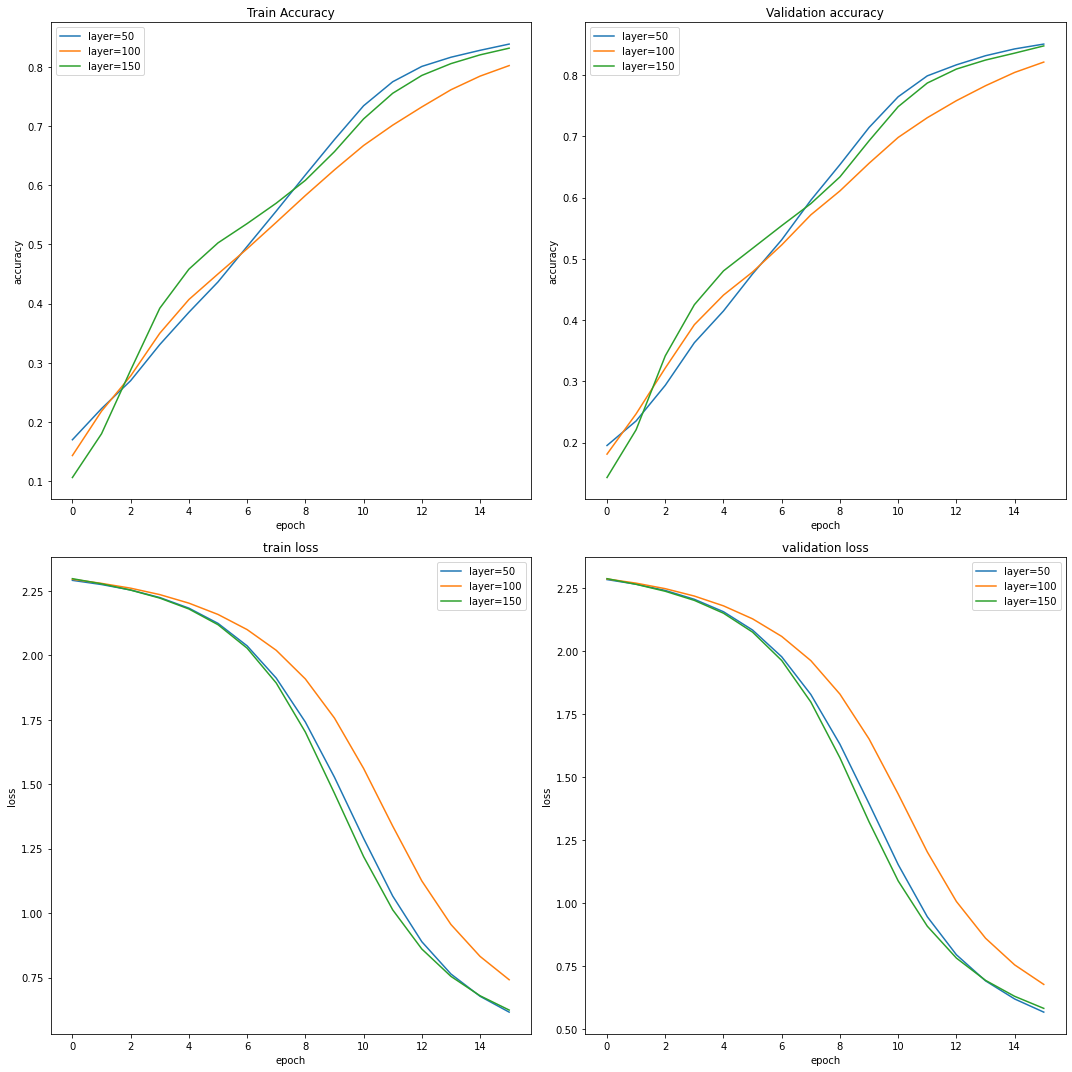

In [59]:
plot_history(scores)

The complexity of the larger model does not increase the accuracy more than the smaller model.

# Evaluation

In [79]:
model = keras.models.load_model('model_v2_0.928.h5')

In [87]:
(_, _), (_, y_true) = mnist.load_data() 

In [91]:
y_predict = np.argmax(model.predict(X_test), axis=1)
print(list(zip(y_true,y_predict))[0:10])

313/313 [==============================] - 2s 5ms/step
[(7, 7), (2, 2), (1, 1), (0, 0), (4, 4), (1, 1), (4, 4), (9, 9), (5, 6), (9, 9)]


[Text(0.5, 51.0, 'Predicted'), Text(51.0, 0.5, 'Actual')]

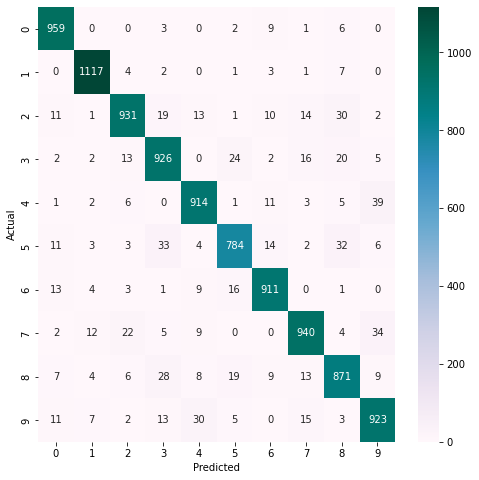

In [118]:
from sklearn.metrics import classification_report, confusion_matrix


classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

cm = confusion_matrix(y_true,y_predict)

cm_df = pd.DataFrame(cm ,columns=classes,index=classes)
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

There is a major confusion of the model between the classes:
* 4 - 9
* 3 - 8
* 3 - 5 

In [93]:
print(classification_report(y_true,y_predict, labels=classes))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.90      0.92      1032
           3       0.90      0.92      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.88      0.90       892
           6       0.94      0.95      0.95       958
           7       0.94      0.91      0.92      1028
           8       0.89      0.89      0.89       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



The model is very good classifying between 0,1,2 and 7

but a little worse in 3 and 7

# Export Model to TF Lite

In [120]:
import tensorflow as tf
from tensorflow import keras


model = keras.models.load_model('model_v2_0.928.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('digits.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp8ovyhrl1\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp8ovyhrl1\assets
